In [ ]:
# pull training data and link it to analysis-ready data
# todo: either access locally or use Window to access on S3 (might need to use bbox instead though)

In [2]:
import os

try:
    from common.sagemaker_env import LABELBOX_API_KEY
except: 
    LABELBOX_API_KEY = os.environ['LABELBOX_API_KEY']

In [24]:
from datetime import datetime, timedelta
from labelbox import Client


client = Client(api_key=LABELBOX_API_KEY)
project = client.get_project("clcrkcvn9281j07xybmww69pn")

now = datetime.today()
then = now - timedelta(days=60)

data_rows = project.export_labels(download=True, start=then.strftime('%Y-%m-%d'), end=now.strftime('%Y-%m-%d'))

81
download: https://data.smartcarte.earth/training/20210101_20210301_south/20210101_20210301_south_all_uint16_cog.tif
(4, 26, 41)


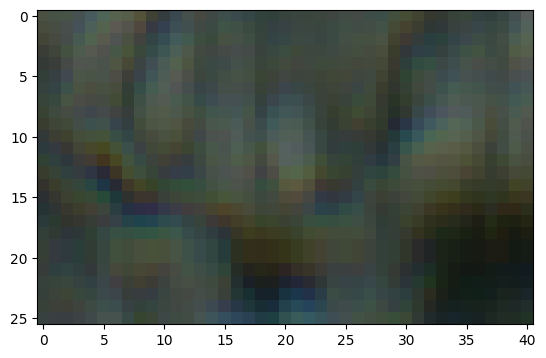

In [63]:
%reload_ext autoreload
%autoreload 2

import json
import matplotlib.pyplot as plt

import common.utilities.download as download
import common.utilities.visualization as visualization


for row in data_rows:
    row_id = row['ID']
    metadata = json.loads(row['Labeled Data'])
    rgb_cog_url = metadata['tileLayerUrl']
    all_cog_url = rgb_cog_url.replace('rgb_byte_cog', 'all_uint16_cog')
    
    labels = row['Label']['objects']
    print(len(labels))
    for label in labels:
        class_title = label['title']
        class_value = label['value']
        geometry = label['geometry']
        coordinates = geometry['coordinates'][0][:-1]
            
        longitudes = [coord[0] for coord in coordinates]
        latitudes = [coord[1] for coord in coordinates]
        
        x_min, y_min = min(longitudes), min(latitudes)
        x_max, y_max = max(longitudes), max(latitudes)
         
        bbox = [x_min, y_min, x_max, y_max]      
        
        data = download.download_bbox(bbox, all_cog_url, read_all=True)
        print(data.shape)

        visualization.plot_bands(data, bands=[2, 1, 0])
        
        # TODO: not really sure how to save this info?
        # TODO: probably need to come up with ML strategry first.
        
        break
    